# eICU Collaborative Research Database

This notebook generates the tables and figures from the eICU Collaborative Research Database paper.

In [1]:
from __future__ import print_function

# Import libraries
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import os
import tableone

# print out pretty pandas dataframes
from IPython.display import display, HTML

from collections import OrderedDict

/home/alistairewj/.local/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Plot settings
%matplotlib inline
plt.style.use('ggplot')
fontsize = 20 # size for x and y ticks
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams.update({'font.size': fontsize})

In [3]:
# Database config
sqluser = 'postgres'
dbname = 'eicu'
schema_name = 'eicu_crd'
sqlhost = 'localhost'
sqlport = 5647

In [4]:
# Connect to the database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=sqlhost, port=sqlport)
query_schema = 'SET search_path to public,' + schema_name + ';'

## Display list of tables

In [5]:
query = \
"""
SELECT tablename 
FROM pg_catalog.pg_tables 
WHERE schemaname like 'eicu_crd'
ORDER BY tablename;
"""

list_of_tables = pd.read_sql_query(query,con)
list_of_tables

,tablename
0,admissiondrug
1,admissiondx
2,allergy
3,apacheapsvar
4,apachepatientresult
5,apachepredvar
6,careplancareprovider
7,careplaneol
8,careplangeneral
9,careplangoal


## Demographics

In [6]:
query = query_schema + \
"""
select
    pt.PATIENTUNITSTAYID
  , pt.patienthealthsystemstayid
  , pt.uniquepid
  , pt.hospitalid
  , pt.wardid

  -- **************************** --
  -- ******* DEMOGRAPHICS ******* --
  -- **************************** --
  
  -- patient features
  , pt.gender
  , pt.age
  , case
      when pt.age = '> 89' then 90
      when pt.age = '' then NULL
    else cast(pt.age as NUMERIC)
    end as age_numeric
  , pt.ethnicity

  -- hospital level features
  , hp.numbedscategory as hospital_size
  , hp.teachingstatus as hospital_teaching_status
  , hp.region as hospital_region
  
  -- patient hospital stay features
  , (hospitaldischargeoffset - hospitaladmitoffset) / 60.0 / 24.0 as hospital_los
  , pt.hospitaldischargelocation
  , pt.hospitaldischargestatus -- 'Expired', 'Alive', ''
  , apv.diedinhospital
  
  , pt.hospitaldischargeyear

  -- ICU length of stay in days
  , pt.unitdischargeoffset / 60.0 / 24.0 as unit_los
  , pt.unittype
  , pt.unitadmitsource
  , pt.unitdischargelocation
  , pt.unitdischargestatus

  -- APACHE covariates for discharge location, etc
  , apv.admitsource
  , apv.dischargelocation
  , apv.bedcount
  , apv.readmit

  -- APACHE IVa
  , ag.apachedxgroup
  , pt.apacheadmissiondx

  -- apache comorbidities
  , aav.dialysis
  , apv.aids
  , apv.hepaticfailure
  , apv.cirrhosis
  , apv.diabetes
  , apv.immunosuppression
  , apv.leukemia
  , apv.lymphoma
  , apv.metastaticcancer
  , apv.thrombolytics

  , pt.admissionheight -- height in cm
  , pt.admissionweight -- weight in kg

  -- ********************** --
  -- *** APACHE APS VAR *** --
  -- ********************** --

  , aav.eyes
  , aav.motor
  , aav.verbal
  , aav.eyes + aav.motor + aav.verbal as GCS
  , aav.meds as UnableGCS
  , aav.urine
  , aav.pao2
  , aav.fio2
  , case when aav.pao2 = -1 or aav.fio2 = -1
      then -1
    else
      aav.pao2 / aav.fio2 * 100
    end as pao2fio2_apache


  -- APACHE vital signs
  , aav.temperature
  , aav.respiratoryrate
  , aav.heartrate
  , aav.meanbp

  -- APACHE labs
  -- Noteably, APACHE does not include lactate, platelets, INR, WBC, or PTT
  , aav.albumin
  , aav.bilirubin
  , aav.bun
  , aav.creatinine
  , aav.glucose
  , aav.hematocrit
  , aav.sodium
  , aav.pco2
  , aav.ph
  , aav.intubated
  , aav.wbc

  -- *********************** --
  -- *** APACHE PRED VAR *** --
  -- *********************** --

  -- Mechanical ventilation start and stop times are interfaced into
  -- or documented directly into the respiratory flow sheet
  -- or by updating the care plan in eCareManager.
  -- however, we decided not to use flow sheet, but to use APACHE vent variable.

  , apv.oobIntubDay1 as oobIntubDay1
  , apv.oobVentDay1 as oobVentDay1
  , apv.VENTDAY1 as VentDay1

  -- APACHE PATIENT RESULT --
  , apr.physicianSpeciality as physicianSpeciality
  , apr.acutePhysiologyScore as acutePhysiologyScore
  , apr.apacheScore as apacheScore
  , apr.predictedICUMortality as predictedICUMortality
  , apr.predictedICULOS as predictedICULOS
  , apr.predictedHospitalMortality as predictedHospitalMortality
  , apr.predictedHospitalLOS as predictedHospitalLOS
  , apr.preopMI as preopMI
  , apr.preopCardiacCath as preopCardiacCath
  , apr.PTCAwithin24h as PTCAwithin24h
  , apv.graftCount

from patient pt
left join hospital hp
  on pt.hospitalid = hp.hospitalid
left join apachepredvar apv
  on pt.patientunitstayid = apv.patientunitstayid
left join apacheapsvar aav
  on pt.patientunitstayid = aav.patientunitstayid
left join apachepatientresult apr
  on pt.patientunitstayid = apr.patientunitstayid
  and apr.apacheversion = 'IVa'
left join apache_groups ag
  on pt.patientunitstayid = ag.patientunitstayid
"""

df = pd.read_sql_query(query,con)

In [7]:
# patient counts
N_STAYS = df['patientunitstayid'].nunique()
# note that the number of unique patientunitstayid == df.shape[0]
print('{:6d} unit stays.'.format(N_STAYS))
print('{:6d} hospital stays.'.format(df['patienthealthsystemstayid'].nunique()))
print('{:6d} patients.'.format(df['uniquepid'].nunique()))
print('{:6d} hospitals.'.format(df['hospitalid'].nunique()))
print('{:6d} units (wards).'.format(df['wardid'].nunique()))

200859 unit stays.
166355 hospital stays.
139367 patients.
   208 hospitals.
   335 units (wards).


In [8]:
# collapse some categories
df['gender_grouped'] = df['gender']
df.loc[ df['gender_grouped'] == 'Other', 'gender_grouped'] = 'Other or Unknown'
df.loc[ df['gender_grouped'] == 'Unknown', 'gender_grouped'] = 'Other or Unknown'

In [9]:
categorical = [u'gender_grouped',
               u'ethnicity', u'hospital_size', u'hospital_teaching_status',
               u'hospital_region', 
               u'hospitaldischargeyear',
               u'unittype',
               # don't include admit/disch locations
               # u'unitadmitsource', u'unitdischargelocation',
               # u'hospitaldischargelocation',
               
               #  below are from apache table
               # u'admitsource', u'dischargelocation',
               u'unitdischargestatus', 
               u'hospitaldischargestatus'
               #u'readmit', 
               # too many categories
               # u'apacheadmissiondx', u'physicianspeciality',
               # below are infrequently documented
               #u'preopmi', u'preopcardiaccath', u'ptcawithin24h', u'graftcount'
              ]

# columns we want to include
columns = ['age_numeric'
           , u'unit_los', u'hospital_los'
           , u'diedinhospital'
           , u'admissionheight', u'admissionweight'
          ]

In [10]:
# output these demographics to a markdown file
t1 = tableone.TableOne(df, columns=columns + categorical, categorical=categorical,
                       nonnormal=['age_numeric', 'unit_los', 'hospital_los'])
print(t1.to_latex())

/home/alistairewj/.virtualenvs/eicu/lib/python3.5/site-packages/modality.py:930: RuntimeWarning: divide by zero encountered in double_scalars
  k_start = (yU[1]-yU[0])/(xU[1]-xU[0])


\begin{tabular}{llll}
\toprule
                &       & isnull &              overall \\
variable & level &        &                      \\
\midrule
n & {} &        &               200859 \\
age\_numeric & {} &     95 &  65.00 [53.00,76.00] \\
unit\_los & {} &      0 &     1.57 [0.82,2.97] \\
hospital\_los & {} &      0 &    5.49 [2.90,10.04] \\
diedinhospital & {} &  29682 &          0.09 (0.29) \\
admissionheight & {} &   4215 &       169.25 (13.69) \\
admissionweight & {} &  16718 &        83.93 (27.09) \\
gender\_grouped & {} &      0 &           134 (0.07) \\
                & Female &        &        92303 (45.95) \\
                & Male &        &       108379 (53.96) \\
                & Other or Unknown &        &            43 (0.02) \\
ethnicity & {} &      0 &          2290 (1.14) \\
                & African American &        &        21308 (10.61) \\
                & Asian &        &          3270 (1.63) \\
                & Caucasian &        &       155285 (77.31) 

## Table of diagnoses

In [11]:
# diagnoses
idxKeep = (~df['predictedhospitalmortality'].isnull()) & (df['predictedhospitalmortality'] != '-1')

t1dx = tableone.TableOne(df.loc[idxKeep,['apacheadmissiondx']],
                         categorical=['apacheadmissiondx'],
                        limit=10)
print(t1dx.tableone.loc['apacheadmissiondx', 'overall'].to_latex())

\begin{tabular}{ll}
\toprule
{} &      overall \\
level                                              &              \\
\midrule
Sepsis, pulmonary                                  &  6823 (5.01) \\
Infarction, acute myocardial (MI)                  &  5919 (4.34) \\
CVA, cerebrovascular accident/stroke               &  5284 (3.88) \\
CHF, congestive heart failure                      &  4840 (3.55) \\
Sepsis, renal/UTI (including bladder)              &  4284 (3.14) \\
Diabetic ketoacidosis                              &  4001 (2.94) \\
CABG alone, coronary artery bypass grafting        &  3635 (2.67) \\
Rhythm disturbance (atrial, supraventricular)      &  3474 (2.55) \\
Cardiac arrest (with or without respiratory arr... &  3377 (2.48) \\
Emphysema/bronchitis                               &  3304 (2.43) \\
\bottomrule
\end{tabular}



## Table of APACHE diagnoses grouped by clinical meaning

In [12]:
pretty_names = {'Sepsis': 'Sepsis'
, 'CVA': 'Cerebrovascular accident'
, 'CardiacArrest': 'Cardiac Arrest'
, 'ACS': 'Acute Coronary Syndrome'
, 'RespMedOther': 'Respiratory medicine'
, 'GIBleed': 'Gastrointestinal Bleed'
, 'Trauma': 'Congestive Heart Failure'
, 'CHF': 'Trauma'
, 'CABG': 'Coronary Artery Bypass Graft'
, 'Neuro': 'Neurological'
, 'PNA': 'Pneumonia'
, 'DKA': 'Diabetic Ketoacidosis'
, 'Overdose': 'Overdose'
, 'Asthma-Emphys': 'Asthma/Emphysema'
, 'CVOther': 'Other cardiovascular disease'
, 'ValveDz': 'Valvular disorders'
, 'Coma': 'Coma'
, 'ARF': 'Acute renal failure'
, 'GIObstruction': 'Gastrointestinal obstruction'
, 'ChestPain': 'Chest Pain (unknown cause)'}

# diagnoses for only patients with APACHE predictions
idxKeep = (~df['predictedhospitalmortality'].isnull()) & (df['predictedhospitalmortality'] != '-1')

df_adx = df.loc[idxKeep, ['patientunitstayid','apachedxgroup']].copy()
df_adx['apachedxgroup'] = df_adx['apachedxgroup'].map(pretty_names)
df_adx = df_adx.groupby('apachedxgroup').count()
df_adx['%'] = np.round(df_adx['patientunitstayid']*100.0/(df_adx['patientunitstayid'].sum()),2)

for i, row in df_adx.sort_values('%', ascending=False).iterrows():
    print('{:40s} & {:5g} ({:3.2f}) \\\\'.format(row.name, row['patientunitstayid'], np.round(row['%'],2)))

Sepsis                                   & 18087 (16.40) \\
Cerebrovascular accident                 &  9758 (8.85) \\
Cardiac Arrest                           &  9135 (8.28) \\
Acute Coronary Syndrome                  &  8343 (7.57) \\
Respiratory medicine                     &  7970 (7.23) \\
Gastrointestinal Bleed                   &  7277 (6.60) \\
Congestive Heart Failure                 &  5884 (5.34) \\
Trauma                                   &  5592 (5.07) \\
Coronary Artery Bypass Graft             &  4771 (4.33) \\
Neurological                             &  4640 (4.21) \\
Pneumonia                                &  4577 (4.15) \\
Diabetic Ketoacidosis                    &  4384 (3.98) \\
Overdose                                 &  4268 (3.87) \\
Asthma/Emphysema                         &  3948 (3.58) \\
Other cardiovascular disease             &  3593 (3.26) \\
Valvular disorders                       &  2795 (2.53) \\
Coma                                     &  2082 (1.89)

In [13]:
# diagnoses for only patients with APACHE predictions
idxKeep = (~df['predictedhospitalmortality'].isnull()) & (df['predictedhospitalmortality'] != '-1')
t1dx = tableone.TableOne(df.loc[idxKeep,:], columns=['apachedxgroup'], categorical=['apachedxgroup'])
print('{} - {} = {} missing a diagnosis'.format(df.shape[0], np.sum(idxKeep), df.shape[0]-np.sum(idxKeep)))
t1dx.head()

200859 - 136236 = 64623 missing a diagnosis


isnull      overall
variable      level                            
n                                        136236
apachedxgroup ACS                0  8343 (6.12)
              ARF                   1932 (1.42)
              Asthma-Emphys          3948 (2.9)
              CABG                   4771 (3.5)

## Table of hospital stats

In [14]:
query = query_schema + \
"""
-- hospital level features
select
    hp.hospitalid
  , hp.numbedscategory as hospital_size
  , hp.teachingstatus as hospital_teaching_status
  , hp.region as hospital_region
  , count(distinct pt.patientunitstayid) as n_patients
from hospital hp
inner join patient pt
  on hp.hospitalid = pt.hospitalid
group by hp.hospitalid, hp.numbedscategory, hp.teachingstatus, hp.region
"""

df_hosp = pd.read_sql_query(query,con)

# set null to unknown category so tableone uses desired format
df_hosp['hospital_size'].fillna('Unknown',inplace=True)
df_hosp['hospital_teaching_status'].fillna('Unknown',inplace=True)
df_hosp['hospital_region'].fillna('Unknown',inplace=True)

In [15]:
for h in ['hospital_size','hospital_teaching_status','hospital_region']:
    grp = df_hosp.groupby(h)[['hospitalid','n_patients']].agg({'hospitalid': 'count', 'n_patients': 'sum'})
    grp['hospitalid_%'] = np.round(grp['hospitalid'] / grp['hospitalid'].sum() * 100.0,2)
    grp['n_patients_%'] = np.round(grp['n_patients'] / grp['n_patients'].sum() * 100.0,2)
    display(HTML(grp[['hospitalid', 'hospitalid_%', 'n_patients','n_patients_%']].to_html()))

,hospitalid,hospitalid_%,n_patients,n_patients_%
hospital_size,,,,
100 - 249,62,29.81,41966,20.89
250 - 499,35,16.83,45716,22.76
<100,46,22.12,12593,6.27
>= 500,23,11.06,75305,37.49
Unknown,42,20.19,25279,12.59


,hospitalid,hospitalid_%,n_patients,n_patients_%
hospital_teaching_status,,,,
False,189,90.87,149181,74.27
True,19,9.13,51678,25.73


,hospitalid,hospitalid_%,n_patients,n_patients_%
hospital_region,,,,
Midwest,70,33.65,65950,32.83
Northeast,13,6.25,14429,7.18
South,56,26.92,60294,30.02
Unknown,26,12.50,13838,6.89
West,43,20.67,46348,23.07


## Information on top diagnoses/treatments

In [16]:
# diagnoses
query = query_schema + \
"""
select diagnosisstring
, count(distinct patientunitstayid) as numobs
from diagnosis
group by diagnosisstring
order by numobs desc
"""
df_misc = pd.read_sql_query(query,con)

df_misc['frac_pat'] = df_misc['numobs']/200859*100.0
print('{} unique diagnoses.'.format(df_misc.shape))
display(df_misc.head())

(3933, 3) unique diagnoses.


,diagnosisstring,numobs,frac_pat
0,pulmonary|respiratory failure|acute respirator...,22395,11.149612
1,renal|disorder of kidney|acute renal failure,16375,8.152485
2,endocrine|glucose metabolism|diabetes mellitus,14620,7.278738
3,cardiovascular|ventricular disorders|congestiv...,12819,6.382089
4,pulmonary|pulmonary infections|pneumonia,12347,6.147098


In [17]:
# treatments
query = query_schema + \
"""
select treatmentstring
, count(distinct patientunitstayid) as numobs
from treatment
group by treatmentstring
order by numobs desc
"""
df_treat = pd.read_sql_query(query,con)

df_treat['frac_pat'] = df_treat['numobs']/200859*100.0
print('{} unique treatments.'.format(df_treat.shape))

for i, row in df_treat.iterrows():
    print('{:6g} ({:5.2f}) - {}'.format(
            row['numobs'], row['frac_pat'], row['treatmentstring']))
    if i>=5:
        break

(2711, 3) unique treatments.
 34059 (16.96) - pulmonary|ventilation and oxygenation|mechanical ventilation
 17660 ( 8.79) - pulmonary|radiologic procedures / bronchoscopy|chest x-ray
 15200 ( 7.57) - cardiovascular|intravenous fluid|normal saline administration
 13926 ( 6.93) - pulmonary|ventilation and oxygenation|oxygen therapy (< 40%)|nasal cannula
 12424 ( 6.19) - infectious diseases|medications|therapeutic antibacterials
 12383 ( 6.17) - pulmonary|ventilation and oxygenation|non-invasive ventilation


## Table of top diagnosis groups

In [18]:
# diagnosis groups
query = query_schema + \
"""
with t1 as
(
select substring(diagnosisstring,1,position('|' in diagnosisstring)-1) as dx
, patientunitstayid
from diagnosis
)
select dx, count(distinct patientunitstayid) as numpat
from t1
group by dx
order by numpat desc
"""
df_dxgrp = pd.read_sql_query(query,con)

df_dxgrp['frac_pat'] = df_misc['numobs']/200859*100.0
for i, row in df_dxgrp.sort_values('numpat', ascending=False).iterrows():
    print('{:40s} & {:5,d} ({:3.2f}\%) \\\\'.format(row['dx'].capitalize(),
                                                 row['numpat'],
                                                 row['frac_pat']))

Cardiovascular                           & 104,264 (11.15\%) \\
Pulmonary                                & 64,222 (8.15\%) \\
Neurologic                               & 51,609 (7.28\%) \\
Renal                                    & 43,009 (6.38\%) \\
Endocrine                                & 35,519 (6.15\%) \\
Gastrointestinal                         & 35,223 (6.10\%) \\
Infectious diseases                      & 20,316 (6.01\%) \\
Hematology                               & 19,611 (5.32\%) \\
Burns/trauma                             & 9,208 (5.13\%) \\
Oncology                                 & 7,954 (4.72\%) \\
Toxicology                               & 7,185 (4.47\%) \\
Surgery                                  & 5,723 (3.97\%) \\
General                                  & 1,698 (3.91\%) \\
Transplant                               &   770 (3.75\%) \\
Obstetrics/gynecology                    &    46 (3.52\%) \\
Genitourinary                            &    26 (3.18\%) \\
Musculoskeleta

# Number of observations for vital tables

In [19]:
query = query_schema + \
"""
with t1 as
(
select patientunitstayid
, count(heartrate) as heartrate
, count(respiration) as respiration
, count(sao2) as sao2
, count(temperature) as temperature
, count(cvp) as cvp
, count(etco2) as etco2
, count(systemicsystolic) as systemicsystolic
, count(systemicdiastolic) as systemicdiastolic
, count(systemicmean) as systemicmean
, count(pasystolic) as pasystolic
, count(padiastolic) as padiastolic
, count(pamean) as pamean
, count(st1) as st1
, count(st2) as st2
, count(st3) as st3
, count(icp) as icp
from vitalperiodic
group by patientunitstayid
)
select
  'patient count' as data_type
, sum(case when heartrate > 0 then 1 else 0 end) as heartrate
, sum(case when respiration > 0 then 1 else 0 end) as respiration
, sum(case when sao2 > 0 then 1 else 0 end) as sao2
, sum(case when temperature > 0 then 1 else 0 end) as temperature
, sum(case when cvp > 0 then 1 else 0 end) as cvp
, sum(case when etco2 > 0 then 1 else 0 end) as etco2
, sum(case when systemicsystolic > 0 then 1 else 0 end) as systemicsystolic
, sum(case when systemicdiastolic > 0 then 1 else 0 end) as systemicdiastolic
, sum(case when systemicmean > 0 then 1 else 0 end) as systemicmean
, sum(case when pasystolic > 0 then 1 else 0 end) as pasystolic
, sum(case when padiastolic > 0 then 1 else 0 end) as padiastolic
, sum(case when pamean > 0 then 1 else 0 end) as pamean
, sum(case when st1 > 0 then 1 else 0 end) as st1
, sum(case when st2 > 0 then 1 else 0 end) as st2
, sum(case when st3 > 0 then 1 else 0 end) as st3
, sum(case when icp > 0 then 1 else 0 end) as icp
from t1
UNION
select
  'observation count' as data_type
, sum(heartrate)::numeric / sum(case when heartrate > 0 then 1 else 0 end) as heartrate
, sum(respiration)::numeric / sum(case when respiration > 0 then 1 else 0 end) as respiration
, sum(sao2)::numeric / sum(case when sao2 > 0 then 1 else 0 end) as sao2
, sum(temperature)::numeric / sum(case when temperature > 0 then 1 else 0 end) as temperature
, sum(cvp)::numeric / sum(case when cvp > 0 then 1 else 0 end) as cvp
, sum(etco2)::numeric / sum(case when etco2 > 0 then 1 else 0 end) as etco2
, sum(systemicsystolic)::numeric / sum(case when systemicsystolic > 0 then 1 else 0 end) as systemicsystolic
, sum(systemicdiastolic)::numeric / sum(case when systemicdiastolic > 0 then 1 else 0 end) as systemicdiastolic
, sum(systemicmean)::numeric / sum(case when systemicmean > 0 then 1 else 0 end) as systemicmean
, sum(pasystolic)::numeric / sum(case when pasystolic > 0 then 1 else 0 end) as pasystolic
, sum(padiastolic)::numeric / sum(case when padiastolic > 0 then 1 else 0 end) as padiastolic
, sum(pamean)::numeric / sum(case when pamean > 0 then 1 else 0 end) as pamean
, sum(st1)::numeric / sum(case when st1 > 0 then 1 else 0 end) as st1
, sum(st2)::numeric / sum(case when st2 > 0 then 1 else 0 end) as st2
, sum(st3)::numeric / sum(case when st3 > 0 then 1 else 0 end) as st3
, sum(icp)::numeric / sum(case when icp > 0 then 1 else 0 end) as icp
from t1;
"""
df_vp = pd.read_sql_query(query,con)
df_vp.set_index('data_type',inplace=True)

In [20]:
df_vp.T

data_type,observation count,patient count
heartrate,759.216100,192277.0
respiration,721.709128,178051.0
sao2,700.822933,189646.0
temperature,679.916010,19419.0
cvp,667.564221,28698.0
etco2,529.994369,8346.0
systemicsystolic,596.459168,46667.0
systemicdiastolic,596.512012,46661.0
systemicmean,597.357531,46975.0
pasystolic,381.975901,10789.0


In [23]:
pretty_labels = {'heartrate': 'Heart rate'
, 'respiration': 'Respiration rate'
, 'sao2': 'Peripheral oxygen saturation'
, 'temperature': 'Temperature'
, 'cvp': 'Central venous pressure'
, 'etco2': 'End tidal carbon dioxide concentration'
, 'systemicsystolic': 'Invasive systolic blood pressure'
, 'systemicdiastolic': 'Invasive diastolic blood pressure'
, 'systemicmean': 'Invasive mean blood pressure'
, 'pasystolic': 'Systolic pulmonary artery pressure'
, 'padiastolic': 'Diastolic pulmonary artery pressure'
, 'pamean': 'Mean pulmonary artery pressure'
, 'st1': 'ST level'
, 'st2': 'ST level'
, 'st3': 'ST level'
, 'icp': 'Intracranial pressure'}

df_vp.sort_values('patient count',axis=1,ascending=False,inplace=True)

for c in df_vp.columns:
    if c != 'data_type':
        print('{:40s}'.format(pretty_labels[c]), end=' & ')
        print('\\colname{:20s}'.format('{' + c + '}'),end=' & ')
        print('{:6,d} ({:3.2f}\%)'.format(
                df_vp.loc['patient count',c].astype(int),
                df_vp.loc['patient count',c].astype(float)/200859*100.0),
              end=' & ')
        print('{:,d} ({:3.1f})'.format((df_vp.loc['observation count',c]*df_vp.loc['patient count',c]).astype(int),
                               df_vp.loc['observation count',c]),
              end=' \\\\\n')

Heart rate                               & \colname{heartrate}          & 192,277 (95.73\%) & 145,979,794 (759.2) \\
Peripheral oxygen saturation             & \colname{sao2}               & 189,646 (94.42\%) & 132,908,266 (700.8) \\
Respiration rate                         & \colname{respiration}        & 178,051 (88.64\%) & 128,501,032 (721.7) \\
ST level                                 & \colname{st2}                & 98,886 (49.23\%) & 59,949,273 (606.2) \\
ST level                                 & \colname{st1}                & 95,643 (47.62\%) & 56,604,917 (591.8) \\
ST level                                 & \colname{st3}                & 92,752 (46.18\%) & 55,201,239 (595.1) \\
Invasive mean blood pressure             & \colname{systemicmean}       & 46,975 (23.39\%) & 28,060,870 (597.4) \\
Invasive systolic blood pressure         & \colname{systemicsystolic}   & 46,667 (23.23\%) & 27,834,959 (596.5) \\
Invasive diastolic blood pressure        & \colname{systemicdiastolic}  & 

In [24]:
# vital aperiodic
query = query_schema + \
"""
with t1 as
(
select patientunitstayid
, count(noninvasivesystolic) as noninvasivesystolic
, count(noninvasivediastolic) as noninvasivediastolic
, count(noninvasivemean) as noninvasivemean
, count(paop) as paop
, count(cardiacoutput) as cardiacoutput
, count(cardiacinput) as cardiacinput
, count(svr) as svr
, count(svri) as svri
, count(pvr) as pvr
, count(pvri) as pvri
from vitalaperiodic
group by patientunitstayid
)
select
  sum(case when noninvasivesystolic > 0 then 1 else 0 end) as noninvasivesystolic
, sum(case when noninvasivediastolic > 0 then 1 else 0 end) as noninvasivediastolic
, sum(case when noninvasivemean > 0 then 1 else 0 end) as noninvasivemean
, sum(case when paop > 0 then 1 else 0 end) as paop
, sum(case when cardiacoutput > 0 then 1 else 0 end) as cardiacoutput
, sum(case when cardiacinput > 0 then 1 else 0 end) as cardiacinput
, sum(case when svr > 0 then 1 else 0 end) as svr
, sum(case when svri > 0 then 1 else 0 end) as svri
, sum(case when pvr > 0 then 1 else 0 end) as pvr
, sum(case when pvri > 0 then 1 else 0 end) as pvri
from t1;
"""
df_vap = pd.read_sql_query(query,con)

In [25]:
df_vap.T

,0
noninvasivesystolic,189620
noninvasivediastolic,189626
noninvasivemean,189663
paop,2072
cardiacoutput,5591
cardiacinput,4203
svr,5022
svri,4156
pvr,1898
pvri,1875


In [26]:
for c in df_vap.columns:
    print('{:6g} ({:5.2f}%) - {}'.format(
            df_vap.loc[0,c],
            df_vap.loc[0,c].astype(float)/200859*100.0,
            c))

189620 (94.40%) - noninvasivesystolic
189626 (94.41%) - noninvasivediastolic
189663 (94.43%) - noninvasivemean
  2072 ( 1.03%) - paop
  5591 ( 2.78%) - cardiacoutput
  4203 ( 2.09%) - cardiacinput
  5022 ( 2.50%) - svr
  4156 ( 2.07%) - svri
  1898 ( 0.94%) - pvr
  1875 ( 0.93%) - pvri


## Number of distinct laboratory measurements per patient

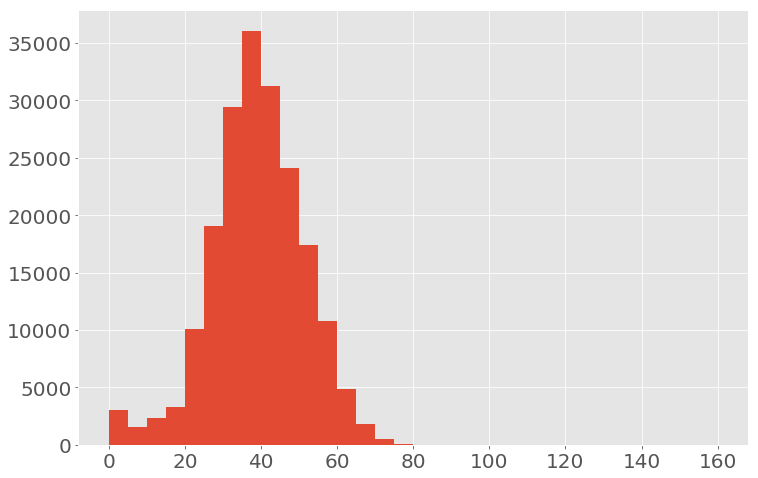

In [27]:
# query to load data from the patient table
query = query_schema + \
"""
SELECT patientunitstayid
, COUNT(DISTINCT labname) AS num_distinct_labs
FROM lab
GROUP BY patientunitstayid
"""

df_lab = pd.read_sql_query(query, con)

plt.figure(figsize=[12,8])
plt.hist(df_lab['num_distinct_labs'], bins=np.linspace(0,160,33))
plt.show()

## Funnel plot

In [28]:
query = query_schema + \
"""
SELECT pt.patientunitstayid, pt.hospitalid
, apr.predictedhospitalmortality as pred
, CASE WHEN pt.hospitaldischargestatus = 'Expired' then 1
       WHEN pt.hospitaldischargestatus = 'Alive' then 0
    else NULL end as target
FROM patient pt
INNER JOIN apachepatientresult apr
ON pt.patientunitstayid = apr.patientunitstayid
AND apr.apacheversion = 'IVa'
WHERE apr.predictedhospitalmortality != ''
AND apr.predictedhospitalmortality IS NOT NULL
AND apr.predictedhospitalmortality != '-1'
AND pt.hospitaldischargestatus in ('Alive','Expired')
"""

df = pd.read_sql_query(query,con)
df['pred'] = pd.to_numeric(df['pred'])

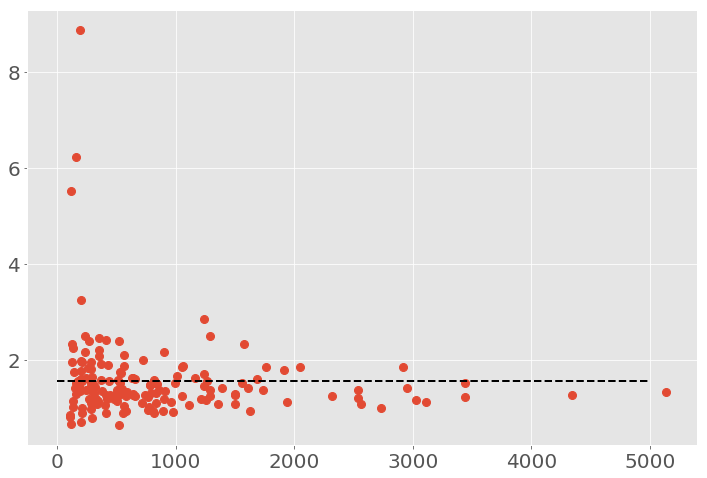

In [29]:
# count patients per hospital
idx = df.groupby('hospitalid')['patientunitstayid'].count()
# isolate to only those with count >= 100
idx = idx.index[idx>=100]
# create index for df
idx = np.in1d(df['hospitalid'],idx)

grp = df.loc[idx,:].groupby('hospitalid')

plt.figure(figsize=[12,8])
plt.plot(grp['patientunitstayid'].count(),
         grp['pred'].mean() / grp['target'].mean(),
        'o', markersize=8)

plt.plot([0,5000],
         np.ones(2) * np.mean(grp['pred'].mean() / grp['target'].mean()),
        'k--', linewidth=2)
plt.show()

## Data completion for patientunitstayid

Below query returns whether a `patientUnitStayId` is in each table in the database.

In [30]:
# query to load data from the patient table
query = query_schema + \
"""
SELECT
  pt.patientunitstayid, pt.hospitalid
  , CASE WHEN adx.patientunitstayid  IS NOT NULL then 1 else 0 end as admissionDx
  , CASE WHEN adr.patientunitstayid  IS NOT NULL then 1 else 0 end as admissionDrug
  , CASE WHEN al.patientunitstayid   IS NOT NULL THEN 1 ELSE 0 END AS allergy
  , CASE WHEN aav.patientunitstayid  IS NOT NULL then 1 else 0 end as apacheApsVar
  , CASE WHEN apv.patientunitstayid  IS NOT NULL then 1 else 0 end as apachePredVar
  , CASE WHEN apr.patientunitstayid  IS NOT NULL then 1 else 0 end as apachePatientResult
  , CASE WHEN cpp.patientunitstayid  IS NOT NULL then 1 else 0 end as carePlanCareProvider
  , CASE WHEN cpe.patientunitstayid  IS NOT NULL then 1 else 0 end as carePlanEOL
  , CASE WHEN cpg.patientunitstayid  IS NOT NULL then 1 else 0 end as carePlanGeneral
  , CASE WHEN cpgl.patientunitstayid IS NOT NULL then 1 else 0 end as carePlanGoal
  , CASE WHEN cpi.patientunitstayid  IS NOT NULL then 1 else 0 end as carePlanInfectiousDisease
  , CASE WHEN cl.patientunitstayid   IS NOT NULL THEN 1 ELSE 0 END AS customLab
  , CASE WHEN di.patientunitstayid   IS NOT NULL then 1 else 0 end as diagnosis
  , CASE WHEN id.patientunitstayid   IS NOT NULL then 1 else 0 end as infusionDrug
  , CASE WHEN io.patientunitstayid   IS NOT NULL THEN 1 ELSE 0 END AS intakeOutput
  , CASE WHEN la.patientunitstayid   IS NOT NULL then 1 else 0 end as lab
  , CASE WHEN me.patientunitstayid   IS NOT NULL then 1 else 0 end as medication
  , CASE WHEN mi.patientunitstayid   IS NOT NULL THEN 1 ELSE 0 END AS microLab
  , CASE WHEN no.patientunitstayid   IS NOT NULL THEN 1 ELSE 0 END AS note
  , CASE WHEN na.patientunitstayid   IS NOT NULL THEN 1 ELSE 0 END AS nurseAssessment
  , CASE WHEN nca.patientunitstayid  IS NOT NULL THEN 1 ELSE 0 END AS nurseCare
  , CASE WHEN nc.patientunitstayid   IS NOT NULL THEN 1 ELSE 0 END AS nurseCharting
  , CASE WHEN pa.patientunitstayid   IS NOT NULL then 1 else 0 end as pastHistory
  , CASE WHEN pe.patientunitstayid   IS NOT NULL THEN 1 ELSE 0 END AS physicalExam
  , CASE WHEN rca.patientunitstayid  IS NOT NULL THEN 1 ELSE 0 END AS respiratoryCare
  , CASE WHEN rc.patientunitstayid   IS NOT NULL THEN 1 ELSE 0 END AS respiratoryCharting
  , CASE WHEN tr.patientunitstayid   IS NOT NULL then 1 else 0 end as treatment
  , CASE WHEN va.patientunitstayid   IS NOT NULL then 1 else 0 end as vitalAperiodic
  , CASE WHEN vp.patientunitstayid   IS NOT NULL then 1 else 0 end as vitalPeriodic
FROM patient pt
LEFT JOIN (select distinct patientunitstayid from admissiondx) adx
    ON pt.patientunitstayid = adx.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from admissionDrug) adr
    ON pt.patientunitstayid = adr.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from allergy) al
    ON pt.patientunitstayid = al.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from apacheapsvar) aav
    ON pt.patientunitstayid = aav.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from apachepredvar) apv
    ON pt.patientunitstayid = apv.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from apachepatientresult) apr
    ON pt.patientunitstayid = apr.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from careplancareprovider) cpp
    ON pt.patientunitstayid = cpp.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from careplaneol) cpe
    ON pt.patientunitstayid = cpe.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from careplangeneral) cpg
    ON pt.patientunitstayid = cpg.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from careplangoal) cpgl
    ON pt.patientunitstayid = cpgl.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from careplaninfectiousdisease) cpi
    ON pt.patientunitstayid = cpi.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from customlab) cl
    ON pt.patientunitstayid = cl.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from diagnosis) di
    ON pt.patientunitstayid = di.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from infusionDrug) id
    ON pt.patientunitstayid = id.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from intakeoutput) io
    ON pt.patientunitstayid = io.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from lab) la
    ON pt.patientunitstayid = la.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from medication) me
    ON pt.patientunitstayid = me.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from microlab) mi
    ON pt.patientunitstayid = mi.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from note) no
    ON pt.patientunitstayid = no.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from nurseassessment) na
    ON pt.patientunitstayid = na.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from nursecare) nca
    ON pt.patientunitstayid = nca.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from nursecharting) nc
    ON pt.patientunitstayid = nc.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from pasthistory) pa
    ON pt.patientunitstayid = pa.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from physicalexam) pe
    ON pt.patientunitstayid = pe.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from respiratorycare) rca
    ON pt.patientunitstayid = rca.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from respiratorycharting) rc
    ON pt.patientunitstayid = rc.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from treatment) tr
    ON pt.patientunitstayid = tr.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from vitalaperiodic) va
    ON pt.patientunitstayid = va.patientunitstayid
LEFT JOIN (select distinct patientunitstayid from vitalperiodic) vp
    ON pt.patientunitstayid = vp.patientunitstayid;
"""

df_dc = pd.read_sql_query(query,con)

In [31]:
# group by hospital - percent data completion for each table
grp = df_dc.groupby('hospitalid')

# group into 5 categories:
# 0%, 0-20%, 20-60%, 60-80%, 80-100%
lower_range = [ -1,  0, 20, 60,  80]
upper_range = [  0, 20, 60, 80, 100]
grp = grp.mean()*100.0
num_hosp = grp.shape[0]

df_count = pd.DataFrame(columns=df_dc.columns)
df_count.drop(['patientunitstayid', 'hospitalid'], axis=1, inplace=True)
for i in range(len(upper_range)):
    df_count.loc[i,:] = None
    for c in df_count.columns:
        num_hosp_in_range=np.sum(
            (grp[c] > lower_range[i]) & (grp[c] <= upper_range[i])
            )
        frac_hosp = float(num_hosp_in_range)/num_hosp*100.0
        df_count.loc[i, c] = frac_hosp

In [32]:
# print out header
print('& \\multicolumn{5}{c}{Coverage} \\\\ \\hline')
print('Table Name &')
print('No data (0\%) &')
print('Low coverage (0-20\%) &')
print('Medium coverage (20-60\%) &')
print('High coverage (60-80\%) &')
print('Excellent coverage (80-100\%) \\\\ \\hline')

# print each row
for i, row in df_count.T.iterrows():
    print('{:40s}'.format( '\\tblname{' + row.name + '}'), end=' ')
    for r in row:
        print('& {:5.2f}'.format(r), end=' ')
    print('\\\\')

& \multicolumn{5}{c}{Coverage} \\ \hline
Table Name &
No data (0\%) &
Low coverage (0-20\%) &
Medium coverage (20-60\%) &
High coverage (60-80\%) &
Excellent coverage (80-100\%) \\ \hline
\tblname{admissiondx}                    &  0.48 &  0.48 &  5.77 & 15.38 & 77.88 \\
\tblname{admissiondrug}                  & 41.35 & 24.52 & 19.23 &  2.88 & 12.02 \\
\tblname{allergy}                        & 10.58 & 20.67 & 63.46 &  5.29 &  0.00 \\
\tblname{apacheapsvar}                   &  0.00 &  0.48 &  6.73 & 14.90 & 77.88 \\
\tblname{apachepredvar}                  &  0.00 &  0.48 &  6.73 & 14.90 & 77.88 \\
\tblname{apachepatientresult}            &  8.65 &  0.96 & 16.83 & 12.98 & 60.58 \\
\tblname{careplancareprovider}           &  0.96 &  0.96 & 12.02 & 12.98 & 73.08 \\
\tblname{careplaneol}                    & 53.85 & 46.15 &  0.00 &  0.00 &  0.00 \\
\tblname{careplangeneral}                &  0.48 &  0.00 &  0.48 &  2.40 & 96.63 \\
\tblname{careplangoal}                   & 62.98 & 27.40

In [33]:
df_heatmap = df_count.copy()
df_heatmap = (df_heatmap*256/100).astype(int)
df_heatmap


,admissiondx,admissiondrug,allergy,apacheapsvar,apachepredvar,apachepatientresult,careplancareprovider,careplaneol,careplangeneral,careplangoal,...,nurseassessment,nursecare,nursecharting,pasthistory,physicalexam,respiratorycare,respiratorycharting,treatment,vitalaperiodic,vitalperiodic
0,1,105,27,0,0,22,2,137,1,161,...,236,238,1,1,1,62,28,16,2,2
1,1,62,52,1,1,2,2,118,0,70,...,4,2,2,1,1,105,39,8,0,0
2,14,49,162,17,17,43,30,0,1,2,...,2,2,4,11,9,84,91,33,9,8
3,39,7,13,38,38,33,33,0,6,11,...,0,0,11,44,45,1,24,29,13,6
4,199,30,0,199,199,155,187,0,247,11,...,12,12,236,198,198,1,72,168,230,238


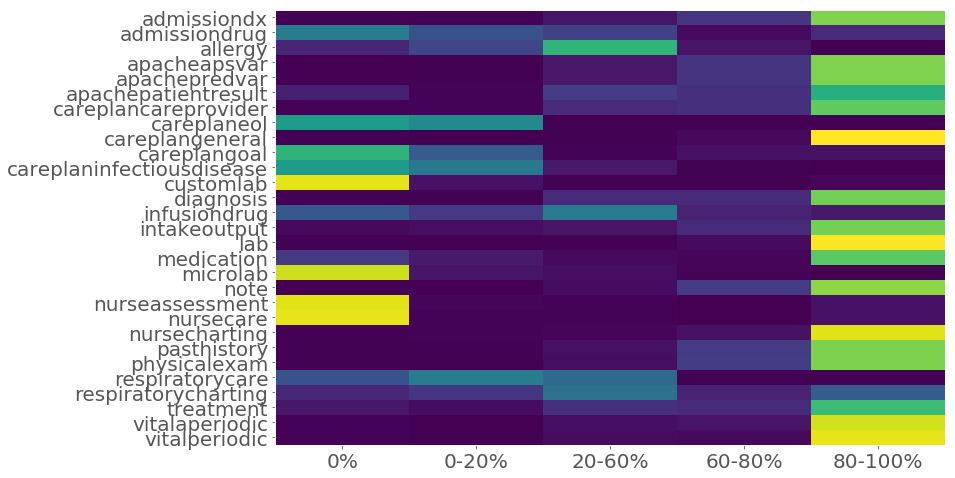

In [34]:
plt.figure(figsize=[12,8])
plt.plot()
plt.imshow(df_heatmap.T, interpolation='none', aspect='auto')
plt.yticks(np.arange(df_heatmap.shape[1]), df_heatmap.columns)
plt.xticks(np.arange(5), ['0%', '0-20%','20-60%','60-80%','80-100%'])
# disable grid
plt.grid()
plt.show()

## Figure for a single patient

In [35]:
# select a single ICU stay
patientunitstayid = 142493
query_schema = 'set search_path to eicu_crd_demo;'

In [36]:
# print APACHE diagnosis for patient
query = query_schema + \
"""
SELECT patientunitstayid
, apacheadmissiondx as dx
FROM patient
WHERE patientunitstayid = """ + str(patientunitstayid) + """
"""

dx = pd.read_sql_query(query,con)
print('Diagnosis: {}'.format(dx.loc[0,'dx']))

Diagnosis: Complications of prev. peripheral vasc. surgery,surgery for (i.e.ligation of bleeder, exploration and evacuation of hematoma, debridement, pseudoaneurysms, clots, fistula, etc.)


In [37]:
# pull lab data
query = query_schema + \
"""
SELECT patientunitstayid
, labresultoffset as "offset"
, labname as "label"
, labresult as "value"
FROM lab
WHERE patientunitstayid = """ + str(patientunitstayid) + """
ORDER BY "offset"
"""

lab = pd.read_sql_query(query,con)
lab.head()

,patientunitstayid,offset,label,value
0,142493,15,bedside glucose,145.0
1,142493,50,Hgb,8.2
2,142493,50,Hct,23.7
3,142493,50,platelets x 1000,65.0
4,142493,180,paCO2,28.0


In [38]:
# pull meds data
query = query_schema + \
"""
SELECT patientunitstayid
, drugstartoffset as "offset"
, drugname as "label"
, dosage as "value"
FROM medication
WHERE patientunitstayid = """ + str(patientunitstayid) + """
AND drugname IS NOT NULL
AND dosage IS NOT NULL
ORDER BY "offset"
"""

med = pd.read_sql_query(query,con)
med.head()

,patientunitstayid,offset,label,value
0,142493,115,3 ML - IPRATROPIUM-ALBUTEROL 0.5-2.5 (3) MG/...,3 1
1,142493,312,MORPHINE INJ,3 3
2,142493,668,1 ML - NALOXONE HCL 0.4 MG/ML IJ SOLN,0.1 3
3,142493,670,OXYCODONE HCL 5 MG PO TABS,5 3
4,142493,1122,CLOPIDOGREL BISULFATE 75 MG PO TABS,75 3


In [39]:
# pull meds data
query = query_schema + \
"""
SELECT patientunitstayid
, intakeoutputoffset as "offset"
, celllabel as "label"
, cellvaluenumeric as "value"
FROM intakeoutput
WHERE patientunitstayid = """ + str(patientunitstayid) + """
AND celllabel IS NOT NULL
AND cellvaluenumeric IS NOT NULL
ORDER BY "offset"
"""

io = pd.read_sql_query(query,con)
io.head()

,patientunitstayid,offset,label,value
0,142493,87,Volume-Transfuse platelet pheresis,250.0
1,142493,132,Volume-Transfuse platelet pheresis,250.0
2,142493,237,Volume-Transfuse red blood cells,350.0
3,142493,342,P.O.,50.0
4,142493,582,P.O.,50.0


In [40]:
# pull infusion drug data
query = query_schema + \
"""
SELECT patientunitstayid
, infusionoffset as "offset"
, drugname as "label"
, coalesce(drugrate,infusionrate) as "value"
FROM infusiondrug
WHERE patientunitstayid = """ + str(patientunitstayid) + """
AND coalesce(drugrate, infusionrate) IS NOT NULL
AND drugname IS NOT NULL
ORDER BY "offset"
"""

inf = pd.read_sql_query(query,con)
inf.head()

,patientunitstayid,offset,label,value


In [41]:
# pull vitalaperiodic data
query = query_schema + \
"""
SELECT patientunitstayid
, observationoffset as "offset"
, noninvasivesystolic sysbp
, noninvasivediastolic diasbp
, noninvasivemean meanbp
FROM vitalaperiodic
WHERE patientunitstayid = """ + str(patientunitstayid) + """
AND noninvasivemean IS NOT NULL
ORDER BY "offset"
"""
vap = pd.read_sql_query(query,con)
vap.head()

,patientunitstayid,offset,sysbp,diasbp,meanbp
0,142493,116,121.0,58.0,83.0
1,142493,242,120.0,58.0,83.0
2,142493,321,110.0,55.0,79.0
3,142493,352,118.0,58.0,83.0
4,142493,462,130.0,61.0,88.0


In [42]:
# pull vitalperiodic data
query = query_schema + \
"""
SELECT patientunitstayid
, observationoffset as "offset"
, systemicsystolic sysbp
, systemicdiastolic diasbp
, systemicmean meanbp
, heartrate
, sao2 as spo2
, respiration
FROM vitalperiodic
WHERE patientunitstayid = """ + str(patientunitstayid) + """
ORDER BY "offset"
"""

vp = pd.read_sql_query(query,con)
vp.head()

,patientunitstayid,offset,sysbp,diasbp,meanbp,heartrate,spo2,respiration
0,142493,5,135.0,50.0,83.0,83,100.0,25
1,142493,10,159.0,70.0,105.0,91,100.0,20
2,142493,15,169.0,74.0,114.0,97,100.0,27
3,142493,20,134.0,56.0,88.0,90,98.0,25
4,142493,25,125.0,55.0,83.0,96,98.0,27


In [43]:
# nursecharting data
query = query_schema + \
"""
SELECT patientunitstayid
, nursingchartoffset as "offset"
, avg((case when nursingchartcelltypevallabel = 'Heart Rate' AND nursingchartcelltypevalname = 'Heart Rate' THEN nursingchartvalue ELSE NULL END)::NUMERIC) as HeartRate                 
, avg((case when nursingchartcelltypevallabel = 'Respiratory Rate' AND nursingchartcelltypevalname = 'Respiratory Rate' THEN nursingchartvalue ELSE NULL END)::NUMERIC) as RespiratoryRate           
, avg((case when nursingchartcelltypevallabel = 'Invasive BP' AND nursingchartcelltypevalname = 'Invasive BP Systolic' THEN nursingchartvalue ELSE NULL END)::NUMERIC) as InvasiveBPSystolic       
, avg((case when nursingchartcelltypevallabel = 'Invasive BP' AND nursingchartcelltypevalname = 'Invasive BP Diastolic' THEN nursingchartvalue ELSE NULL END)::NUMERIC) as InvasiveBPDiastolic       
, avg((case when nursingchartcelltypevallabel = 'Arterial Line MAP (mmHg)' AND nursingchartcelltypevalname = 'Value' THEN nursingchartvalue ELSE NULL END)::NUMERIC) as InvasiveBPMean    
, avg((case when nursingchartcelltypevallabel = 'O2 Saturation' AND nursingchartcelltypevalname = 'O2 Saturation' THEN nursingchartvalue ELSE NULL END)::NUMERIC) as spo2
, avg((case when nursingchartcelltypevallabel = 'Non-Invasive BP' AND nursingchartcelltypevalname = 'Non-Invasive BP Diastolic' THEN nursingchartvalue ELSE NULL END)::NUMERIC) as NonInvasiveBPDiastolic  
, avg((case when nursingchartcelltypevallabel = 'Non-Invasive BP' AND nursingchartcelltypevalname = 'Non-Invasive BP Systolic' THEN nursingchartvalue ELSE NULL END)::NUMERIC) as NonInvasiveBPSystolic
, avg((case when nursingchartcelltypevallabel = 'Non-Invasive BP' AND nursingchartcelltypevalname = 'Non-Invasive BP Mean' THEN nursingchartvalue ELSE NULL END)::NUMERIC) as NonInvasiveBPMean
, avg((case when nursingchartcelltypevallabel = 'Temperature' AND nursingchartcelltypevalname = 'Temperature (C)' THEN nursingchartvalue ELSE NULL END)::NUMERIC) as Temperature
, avg((case when nursingchartcelltypevallabel = 'Patient s Comfort/Function (Pain) GOAL At Rest' AND nursingchartcelltypevalname = 'Value' THEN nursingchartvalue ELSE NULL END)::NUMERIC) as paingoal                      
, avg((case when nursingchartcelltypevallabel = 'Pain Score/Goal' AND nursingchartcelltypevalname = 'Pain Score' THEN nursingchartvalue ELSE NULL END)::NUMERIC) as PainScore
, avg((case when nursingchartcelltypevallabel = 'Verbal Response' AND nursingchartcelltypevalname = 'Value' THEN nursingchartvalue ELSE NULL END)::NUMERIC) as verbal
, avg((case when nursingchartcelltypevallabel = 'Eye Opening' AND nursingchartcelltypevalname = 'Value' THEN nursingchartvalue ELSE NULL END)::NUMERIC) as eyes
, avg((case when nursingchartcelltypevallabel = 'Glasgow coma score' AND nursingchartcelltypevalname = 'GCS Total' THEN nursingchartvalue ELSE NULL END)::NUMERIC) as gcs
FROM nursecharting
WHERE patientunitstayid = """ + str(patientunitstayid) + """
GROUP BY patientunitstayid, nursingchartoffset
ORDER BY "offset"
"""

nc = pd.read_sql_query(query,con)
nc.head()

,patientunitstayid,offset,heartrate,respiratoryrate,invasivebpsystolic,invasivebpdiastolic,invasivebpmean,spo2,noninvasivebpdiastolic,noninvasivebpsystolic,noninvasivebpmean,temperature,paingoal,painscore,verbal,eyes,gcs
0,142493,-8,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,142493,-3,66.0,NaN,132.0,54.0,79.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,142493,2,83.0,25.0,130.0,49.0,79.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,142493,7,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,36.8,NaN,NaN,NaN,NaN,NaN
4,142493,8,99.0,17.0,NaN,NaN,NaN,NaN,77.0,170.0,NaN,36.6,NaN,NaN,NaN,NaN,NaN


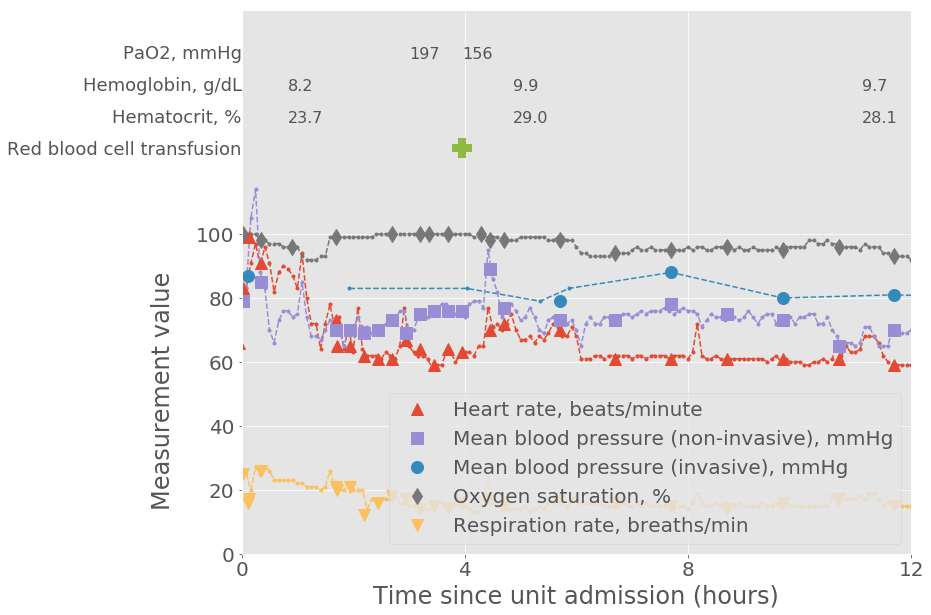

In [44]:
# plot the data

# convert from minutes to our time unit here
TIME_FACTOR = 1.0/60.0
TIME_UNIT = 'hours'

plt.figure(figsize=[12,10])
p_hr = plt.plot(vp['offset']*TIME_FACTOR, vp['heartrate'], '.--', label='_no_legend_')
p_nibp = plt.plot(vap['offset']*TIME_FACTOR, vap['meanbp'], '.--', label='_no_legend_')
p_ibp = plt.plot(vp['offset']*TIME_FACTOR, vp['meanbp'], '.--', label='_no_legend_')
p_o2 = plt.plot(vp['offset']*TIME_FACTOR, vp['spo2'], '.--', label='_no_legend_')
p_rr = plt.plot(vp['offset']*TIME_FACTOR, vp['respiration'], '.--', label='_no_legend_')

# nurse validated
plt.plot(nc['offset']*TIME_FACTOR, nc['heartrate'], '^',
         markersize=12, markerfacecolor=None, color=p_hr[0].get_color(),
         label='Heart rate, beats/minute')
plt.plot(nc['offset']*TIME_FACTOR, nc['invasivebpmean'], 's',
         markersize=12, markerfacecolor=None, color=p_ibp[0].get_color(), label='Mean blood pressure (non-invasive), mmHg')
plt.plot(nc['offset']*TIME_FACTOR, nc['noninvasivebpmean'], 'o',
         markersize=12, markerfacecolor=None, color=p_nibp[0].get_color(), label='Mean blood pressure (invasive), mmHg')
plt.plot(nc['offset']*TIME_FACTOR, nc['spo2'], 'd',
         markersize=12, markerfacecolor=None, color=p_o2[0].get_color(), label='Oxygen saturation, %')
plt.plot(nc['offset']*TIME_FACTOR, nc['respiratoryrate'], 'v',
         markersize=12, markerfacecolor=None, color=p_rr[0].get_color(), label='Respiration rate, breaths/min')
"""
# Plot infusions as a scaled line
infdrg_dict = OrderedDict([
        ['Norepinephrine, mcg/min', [145, 'Norepinephrine (mcg/min)', 0, 10 ]]
        #['Normal Saline (ml/hr)', [155, 'NS (ml/hr)', 0, 500]]
    ])

xloc = 0
for item in infdrg_dict:
    yloc = infdrg_dict[item][0]
    label = infdrg_dict[item][1]
    plot_lo = infdrg_dict[item][2]
    plot_hi = infdrg_dict[item][3]
    
    scale_data = 10.0/(plot_hi-plot_lo)
    plt.text(xloc, yloc, item, fontsize=18, horizontalalignment='right')
    # plot the trend over time
    df_item = inf.loc[inf['label']==label,:]
    # limit to first 2 days
    df_item = df_item.loc[df_item['offset']<=(1440*2),:]
    scaled_data = df_item['value'].astype(float)
    # shift low to 0
    scaled_data = scaled_data - plot_lo
    # shift high to 1
    scaled_data = scaled_data / plot_hi
    # move up to [yloc, yloc+5]
    scaled_data = (scaled_data)*5.0 + yloc
    
    plt.plot( df_item['offset']*TIME_FACTOR, scaled_data, 'o--', label='_nolegend_' )
    
# Plot intake output as a single marker indicating start time
med_dict = OrderedDict([
        ['Normal Saline (ml/hr)', [155, 'NS (ml/hr)', 0, 500]]
    ])

# plot a single marker for each instance - regardless of the value of the instance
xloc = 0
for item in med_dict:
    yloc = med_dict[item][0]
    label = med_dict[item][1]
    plt.text(xloc, yloc, item, fontsize=18, horizontalalignment='right')
    
    df_item = med.loc[med['label']==label,:]
    
    # limit to first 2 days
    df_item = df_item.loc[(df_item['offset']>0) & (df_item['offset']<=(1440*2)),:]
    
    plt.plot( df_item['offset']*TIME_FACTOR, (yloc+2.0)*np.ones(df_item.shape[0]), 'o',
             label='_nolegend_' )
"""

# Plot intake output as a single marker indicating start time
io_dict = OrderedDict([
        ['Red blood cell transfusion', [125, 'Volume-Transfuse red blood cells']]
        #['Normal Saline (ml/hr)', [155, 'NS (ml/hr)', 0, 500]]
    ])

# plot a single marker for each instance - regardless of the value of the instance
xloc = 0
for item in io_dict:
    yloc = io_dict[item][0]
    label = io_dict[item][1]
    plt.text(xloc, yloc, item, fontsize=18, horizontalalignment='right', color='#555555')
    
    df_item = io.loc[io['label']==label,:]
    
    # limit to first 2 days
    df_item = df_item.loc[(df_item['offset']>0) & (df_item['offset']<=(1440*2)),:]
    
    plt.plot( df_item['offset']*TIME_FACTOR, (yloc+2.0)*np.ones(df_item.shape[0]), '+',
             markersize=20, mew=8,
             label='_nolegend_' )

# Plot labs as text on the plot
labs = OrderedDict([
        #['Creatinine, mg/dL', [195, 'creatinine']],
        #['White blood cell, K/uL', [ 185, 'WBC x 1000' ]],
        #['Troponin, g/dL', [175, 'troponin - I']],
        #['Lactate, mmol/L', [175, 'lactate']],
        ['PaO2, mmHg', [155, 'paO2']],
        ['Hemoglobin, g/dL', [145, 'Hgb']],
        ['Hematocrit, %', [135, 'Hct']]
    ])

xloc = 0
for l in labs:
    yloc = labs[l][0]
    label = labs[l][1]
    
    # plot the trend over time
    df_item = lab.loc[lab['label']==label,:]
    # limit to first 2 days
    df_item = df_item.loc[(df_item['offset']<=(1440*2)) & (df_item['offset']>0),:]
    
    plt.text(xloc, yloc, l, fontsize=18, horizontalalignment='right', color='#555555')
    for i, row in df_item.iterrows():
        # put text for pao2 without a decimal
        if l=='PaO2, mmHg':
            v = int(row['value'])
        else:
            v = row['value']
            
        plt.text(row['offset']*TIME_FACTOR, yloc, v,
                 fontsize=16, color='#555555', label='_nolegend_') 

plt.yticks(np.arange(0, 120, 20))
plt.xticks(np.arange(0, 12.01, 4))
plt.xlim([0,12])
plt.ylim([0,170])
plt.xlabel('Time since unit admission (' + TIME_UNIT + ')')
plt.ylabel('Measurement value')
# manually position the y-label
ax = plt.gca()
ax.yaxis.set_label_coords(-0.1, 0.3)
leg = plt.legend(loc='lower right')
plt.setp(leg.get_texts(), color='#555555')
plt.savefig('ExamplePatient.pdf', bbox_inches='tight')
plt.savefig('ExamplePatient.png', bbox_inches='tight')
plt.show()